# Preprocessing and Feature Creation

Data Processing and Feature Engineering is performed in the following, using the given variables downloaded from the Binance API, we will calculate the following:

In [5]:
!pip install ta

In [4]:
# Collecting Cryptocurrency Informations
import torch
from ta.momentum import rsi
from ta.trend import macd
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from ta import add_all_ta_features
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import EMAIndicator, MACD
from ta.volume import VolumeWeightedAveragePrice

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

directory = '/kaggle/input/crypto-2021-10-01-1hour'

# Initialize an empty list to store DataFrames
dataframes = []

for filename in os.listdir(directory):
    if filename.endswith('.csv') and filename != "USDCUSDT1h.csv" and filename != "DAIUSDT1h.csv":
        ticker = filename[:-6] # Remove the '1h.csv' extension
        data = pd.read_csv(os.path.join(directory, filename), parse_dates=['time'])

        cutoff_date = pd.Timestamp('2021-10-01')

        if data['time'].iloc[0] > cutoff_date:
            print(f"Skipping {ticker}: first entry is after 2021-10-01.")
            continue  # Skip this dataset
            
        data = data[data['time'] >= cutoff_date]
       # data = data.iloc[9:]

        # Feature Engineering
        # df['average'] = (df['high'] + df['low'] + df['close'])/3
        # df["DailyLogReturn"] = np.log(1 + df["close"].pct_change())
        # df['price_return'] = (df['close'] - df['open']) / df['open']
        # df["NormClose"] = (df["close"] - df["close"].mean()) / df["close"].std()
        # df["ALR1W"] = df["DailyLogReturn"].rolling(window=5).sum() * 5
        # df["ALR2W"] = df["DailyLogReturn"].rolling(window=10).sum() * 5
        # df["ALR1M"] = df["DailyLogReturn"].rolling(window=21).sum() * 21
        # df["ALR2M"] = df["DailyLogReturn"].rolling(window=42).sum() * 21
        # df['Day of Week'] = df['time'].dt.dayofweek
        # df["RSI"] = rsi(df["close"]) / 100
        # df["MACD"] = macd(df["close"])
        # df['buy_volume_ratio'] = df['buy_base_vol'] / df['volume']
        # df['Ticker'] = ticker

        windows = [5, 10, 20]
        data["DailyLogReturn"] = np.log(1 + data["close"].pct_change())

        data['volume_quote_ratio'] = data['volume'] / data['quote_volume']
        data['buy_sell_volume_ratio'] = data['buy_base_vol'] / data['volume']
        data['buy_sell_quote_ratio'] = data['buy_quote_vol'] / data['quote_volume']

        # Stochastic Oscillator
        stoch = StochasticOscillator(high = data['high'], low = data['low'], close = data['close'])
        data['stoch_k'] = stoch.stoch()
        data['stoch_d'] = stoch.stoch_signal()

        # VWAP
        vwap = VolumeWeightedAveragePrice(high = data['high'], low = data['low'],
                                         close = data['close'], volume = data['volume'])
        data['vwap'] = vwap.volume_weighted_average_price()

        for window in windows:
            # Parkinson Volatility
            data[f'parkinson_vol_{window}'] = np.sqrt(
                (1.0 / (4.0 * np.log(2.0))) *
                (np.log(data['high'] / data['low']) ** 2).rolling(window).mean()
            )

            # Garman-Klass Volatility
            data[f'garman_klass_vol_{window}'] = np.sqrt(
                (0.5 * np.log(data['high'] / data['low']) ** 2) -
                (2.0 * np.log(2.0) - 1.0) * (np.log(data['close'] / data['open']) ** 2)
            ).rolling(window).mean()

        data['avg_trade_size'] = data['volume'] / data['trades']
        data['avg_trade_quote_size'] = data['quote_volume'] / data['trades']
        data["Ticker"] = ticker
        data.set_index('time', inplace = True)
        data.drop(columns = ["open", "low", "high", "quote_volume", "trades", "buy_quote_vol"], inplace=True)
        
        if data.empty:
            print(f"Warning: {ticker} DataFrame is empty.")
            continue

        dataframes.append(data)
        
# Concatenate all DataFrames into a single DataFrame with a hierarchical index
all_data = pd.concat(dataframes, keys=[df['Ticker'][0] for df in dataframes])

# level_0_index = 'OMUSDT'  # Replace with your actual level 0 index value

# # Filter the DataFrame for the specific level 0 index
# filtered_data = all_data.loc[level_0_index]

# # Find rows with missing/NaN values
# missing_data = filtered_data[filtered_data.isna().any(axis=1)]

# Output the rows with missing values

# Drop any rows with missing values and filter time range
all_data = all_data.dropna()
all_data = all_data.loc['2021-10-01':]

# Specify the level 1 index you want to delete
level_1_index_to_delete = pd.Timestamp('2023-06-08 23:00:00')

# Drop the specified level 1 index across all level 0 indexes
all_data = all_data.drop(level_1_index_to_delete, level=1, errors='ignore')

# Display the combined DataFrame
all_data

cuda
Skipping WBETHUSDT: first entry is after 2021-10-01.
Skipping IMXUSDT: first entry is after 2021-10-01.
Skipping RENDERUSDT: first entry is after 2021-10-01.
Skipping SUIUSDT: first entry is after 2021-10-01.
Skipping TONUSDT: first entry is after 2021-10-01.
Skipping POLUSDT: first entry is after 2021-10-01.
Skipping TIAUSDT: first entry is after 2021-10-01.
Skipping ARBUSDT: first entry is after 2021-10-01.
Skipping WLDUSDT: first entry is after 2021-10-01.
Skipping OPUSDT: first entry is after 2021-10-01.
Skipping PYTHUSDT: first entry is after 2021-10-01.
Skipping FLOKIUSDT: first entry is after 2021-10-01.
Skipping APTUSDT: first entry is after 2021-10-01.
Skipping TAOUSDT: first entry is after 2021-10-01.
Skipping LDOUSDT: first entry is after 2021-10-01.
Skipping PEPEUSDT: first entry is after 2021-10-01.
Skipping ENAUSDT: first entry is after 2021-10-01.
Skipping WIFUSDT: first entry is after 2021-10-01.
Skipping JUPUSDT: first entry is after 2021-10-01.
Skipping SEIUSDT: 

/tmp/ipykernel_30/465273891.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_data = pd.concat(dataframes, keys=[df['Ticker'][0] for df in dataframes])


close      volume  buy_base_vol  \
         time                                                     
TRXUSDT  2021-10-01 19:00:00  0.09391  26197437.1    14327682.3   
         2021-10-01 20:00:00  0.09379  21142375.4    10647644.9   
         2021-10-01 21:00:00  0.09440  28949070.6    15277565.4   
         2021-10-01 22:00:00  0.09368  30396440.2    16055595.5   
         2021-10-01 23:00:00  0.09481  19011348.0     9063465.8   
...                               ...         ...           ...   
HBARUSDT 2024-10-31 12:00:00  0.04720   9051037.0     4190212.0   
         2024-10-31 13:00:00  0.04690  12270974.0     6136277.0   
         2024-10-31 14:00:00  0.04640  21930941.0    10278205.0   
         2024-10-31 15:00:00  0.04660  10206661.0     5387607.0   
         2024-10-31 16:00:00  0.04640   6115822.0     3163468.0   

                              DailyLogReturn  volume_quote_ratio  \
         time                                                      
TRXUSDT  2021-10-01 19:00:00        0.005017           10.660610   
         2021-10-01 20:00:00       -0.001279           10.682554   
         2021-10-01 21:00:00        0.006483           10.627296   
         2021-10-01 22:00:00       -0.007656           10.637673   
         2021-10-01 23:00:00        0.011990           10.614308   
...                                      ...                 ...   
HBARUSDT 2024-10-31 12:00:00        0.000000           21.210950   
         2024-10-31 13:00:00       -0.006376           21.264962   
         2024-10-31 14:00:00       -0.010718           21.516218   
         2024-10-31 15:00:00        0.004301           21.483317   
         2024-10-31 16:00:00       -0.004301           21.536471   

                              buy_sell_volume_ratio  buy_sell_quote_ratio  \
         time                                                               
TRXUSDT  2021-10-01 19:00:00               0.546912              0.546931   
         2021-10-01 20:00:00               0.503616              0.503565   
         2021-10-01 21:00:00               0.527739              0.527664   
         2021-10-01 22:00:00               0.528206              0.528180   
         2021-10-01 23:00:00               0.476740              0.476705   
...                                             ...                   ...   
HBARUSDT 2024-10-31 12:00:00               0.462954              0.463167   
         2024-10-31 13:00:00               0.500064              0.500096   
         2024-10-31 14:00:00               0.468662              0.468641   
         2024-10-31 15:00:00               0.527852              0.527996   
         2024-10-31 16:00:00               0.517260              0.517390   

                                stoch_k    stoch_d      vwap  parkinson_vol_5  \
         time                                                                   
TRXUSDT  2021-10-01 19:00:00  92.687386  90.287566  0.092502         0.005954   
         2021-10-01 20:00:00  90.151515  89.091798  0.092634         0.005727   
         2021-10-01 21:00:00  97.222222  93.353708  0.092867         0.005516   
         2021-10-01 22:00:00  74.863388  87.412375  0.093089         0.006091   
         2021-10-01 23:00:00  99.230769  90.438793  0.093213         0.006414   
...                                 ...        ...       ...              ...   
HBARUSDT 2024-10-31 12:00:00  15.000000  12.814992  0.047678         0.005534   
         2024-10-31 13:00:00   5.000000   8.421053  0.047587         0.005543   
         2024-10-31 14:00:00  11.538462  10.512821  0.047358         0.007510   
         2024-10-31 15:00:00  20.833333  12.457265  0.047237         0.007531   
         2024-10-31 16:00:00  12.500000  14.957265  0.047159         0.007189   

                              garman_klass_vol_5  parkinson_vol_10  \
         time                                                        
TRXUSDT  2021-10-01 19:00:00            0.006223          0.009201   
         

In [3]:
row_counts = all_data.groupby(level=0).size()

# 2023-03-24 12:00:00, 2023-06-08 23:00:00

# Print the number of rows for each level 0 index
print(row_counts)

AAVEUSDT     27019
ADAUSDT      27019
ALGOUSDT     27019
ATOMUSDT     27019
AVAXUSDT     27019
BCHUSDT      27019
BNBUSDT      27019
BTCUSDT      27019
DOGEUSDT     27019
DOTUSDT      27019
ETCUSDT      27019
ETHUSDT      27019
FETUSDT      27019
FILUSDT      27019
FTMUSDT      27019
GRTUSDT      27019
HBARUSDT     27019
ICPUSDT      27019
INJUSDT      27019
LINKUSDT     27019
LTCUSDT      27019
MKRUSDT      27019
NEARUSDT     27019
OMUSDT       27019
RUNEUSDT     27019
SHIBUSDT     27019
SOLUSDT      27019
STXUSDT      27019
THETAUSDT    27019
TRXUSDT      27019
UNIUSDT      27019
VETUSDT      27019
XLMUSDT      27019
XRPUSDT      27019
dtype: int64


In [3]:
first_rows = all_data.reset_index(level=1).groupby(level=0).first()

first_rows

,time,close,volume,buy_base_vol,DailyLogReturn,volume_quote_ratio,buy_sell_volume_ratio,buy_sell_quote_ratio,stoch_k,stoch_d,vwap,parkinson_vol_5,garman_klass_vol_5,parkinson_vol_10,garman_klass_vol_10,parkinson_vol_20,garman_klass_vol_20,avg_trade_size,avg_trade_quote_size,Ticker
AAVEUSDT,2021-10-01 19:00:00,302.200000,3.835756e+03,2.375773e+03,0.004311,0.003311,0.619375,0.619472,92.715232,93.811913,293.296201,0.008663,0.009128,0.012010,0.011993,0.011058,0.010438,1.172655e+00,354.204857,AAVEUSDT
ADAUSDT,2021-10-01 19:00:00,2.257000,1.072952e+07,6.311414e+06,0.009795,0.444293,0.588229,0.588305,93.452381,92.919465,2.202314,0.007727,0.007802,0.011611,0.010309,0.009439,0.008421,2.367555e+02,532.881363,ADAUSDT
ALGOUSDT,2021-10-01 19:00:00,1.786500,2.089971e+06,1.074124e+06,-0.000560,0.557406,0.513942,0.513969,86.708555,88.998355,1.725953,0.011892,0.012346,0.016294,0.016011,0.013347,0.012702,2.949021e+02,529.061678,ALGOUSDT
ATOMUSDT,2021-10-01 19:00:00,37.950000,1.549987e+05,7.987109e+04,0.006609,0.026406,0.515302,0.515285,81.230769,78.767774,37.239306,0.009902,0.010004,0.013737,0.014019,0.012466,0.012147,1.568337e+01,593.933043,ATOMUSDT
AVAXUSDT,2021-10-01 19:00:00,68.450000,1.656609e+05,8.423325e+04,0.003219,0.014607,0.508468,0.508490,80.000000,82.910217,67.179546,0.011367,0.011215,0.016428,0.016152,0.014088,0.013477,1.024749e+01,701.522594,AVAXUSDT
BCHUSDT,2021-10-01 19:00:00,540.800000,3.774862e+03,1.997737e+03,-0.000185,0.001848,0.529221,0.529112,92.344498,94.785599,527.576678,0.004978,0.005092,0.009490,0.007445,0.008307,0.007029,1.048864e+00,567.511793,BCHUSDT
BNBUSDT,2021-10-01 19:00:00,420.600000,3.346072e+04,2.022426e+04,0.002619,0.002383,0.604418,0.604482,99.090909,97.916177,407.918793,0.005925,0.005774,0.010790,0.009579,0.009591,0.008616,1.556168e+00,653.034711,BNBUSDT
BTCUSDT,2021-10-01 19:00:00,48030.000000,2.275138e+03,1.275898e+03,0.006388,0.000021,0.560800,0.560930,96.413360,95.241815,46596.470723,0.006052,0.006473,0.013787,0.009980,0.010660,0.007730,3.189863e-02,1528.842374,BTCUSDT
DOGEUSDT,2021-10-01 19:00:00,0.218300,3.213529e+07,1.738646e+07,0.005512,4.586494,0.541039,0.541199,93.452381,90.129156,0.212826,0.007946,0.007817,0.012711,0.010853,0.009746,0.007861,4.105697e+03,895.171154,DOGEUSDT
DOTUSDT,2021-10-01 19:00:00,32.120000,6.811833e+05,4.042985e+05,0.012216,0.031236,0.593524,0.593619,94.246575,94.535168,30.654088,0.011301,0.010797,0.013973,0.013252,0.012083,0.011558,1.316144e+01,421.360939,DOTUSDT


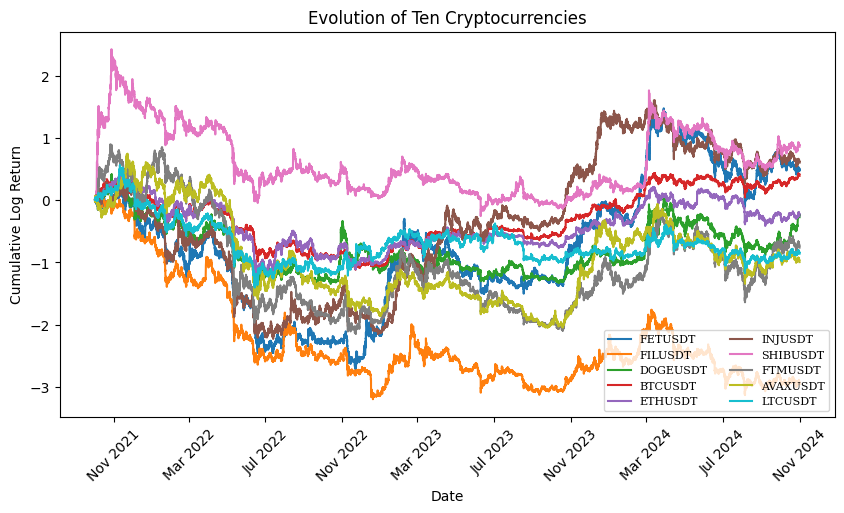

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 5))
tickers = all_data.index.get_level_values(0).unique()

# Randomly select 10 tickers if you want a subset
selected_tickers = np.random.choice(tickers, size=10, replace=False)

for ticker in selected_tickers:
	plt.plot(all_data.loc[ticker].index, 
             np.cumsum(all_data.loc[ticker]["DailyLogReturn"]), 
             label=f'{ticker}')
plt.title("Evolution of Ten Cryptocurrencies")
plt.xlabel('Date')
plt.gca().tick_params(axis='x', rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.ylabel('Cumulative Log Return')
plt.legend(ncol=2, loc="lower right", prop={'size': 8, 'family': 'serif'})
plt.show()

# Correlation between Cryptocurrency

Computing the correlation between currencies to initialise the edges for the graph. Current method utilises a date range to compute correlation (2023-10-01 to 2024-10-01). Preferably, we would use fundamental information about each currency for correlation

In [7]:
df_close = all_data.copy()

# Reset the index to access the time column
df_close.reset_index(inplace=True)

df_close = df_close[["time", "Ticker", "close"]]
df_close["time"] = pd.to_datetime(df_close["time"])
df_close.set_index("time", inplace=True)

# Sort the DataFrame by index to ensure it is monotonic
df_close.sort_index(inplace=True)

df_close["close"] = np.log(df_close["close"])

# Filter for dates in 2024
df_close_filtered = df_close.loc['2024-01-01':'2024-10-01']

# Reset index to prepare for pivoting
df_close_filtered.reset_index(inplace=True)

# Create a pivot table to reshape the DataFrame
df_close_filtered = pd.pivot_table(
    df_close_filtered, values="close", columns="Ticker", index="time"
)

df_close_filtered

Ticker,AAVEUSDT,ADAUSDT,ALGOUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,DOTUSDT,...,RUNEUSDT,SHIBUSDT,SOLUSDT,STXUSDT,THETAUSDT,TRXUSDT,UNIUSDT,VETUSDT,XLMUSDT,XRPUSDT
time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,4.704291,-0.514332,-1.490322,2.370057,3.662022,5.560297,5.750666,10.656676,-2.409836,2.112272,...,1.645191,-11.475630,4.624581,0.398709,0.248421,-2.222665,1.989654,-3.363035,-2.046394,-0.484184
2024-01-01 01:00:00,4.713576,-0.507000,-1.488106,2.372298,3.673512,5.562987,5.753525,10.659928,-2.406169,2.115532,...,1.649043,-11.471784,4.645544,0.412242,0.238229,-2.223774,1.994972,-3.358713,-2.042531,-0.480458
2024-01-01 02:00:00,4.703385,-0.511659,-1.496556,2.367717,3.664587,5.560682,5.739471,10.659166,-2.410170,2.110577,...,1.643646,-11.474667,4.641406,0.416867,0.231905,-2.227385,1.988833,-3.359864,-2.047943,-0.485483
2024-01-01 03:00:00,4.688868,-0.518186,-1.504177,2.358020,3.650918,5.554122,5.733988,10.653263,-2.416762,2.097772,...,1.633740,-11.483367,4.635408,0.392380,0.217528,-2.233899,1.976578,-3.373485,-2.052605,-0.489390
2024-01-01 04:00:00,4.689236,-0.518690,-1.506430,2.354703,3.643097,5.549854,5.733988,10.654903,-2.417996,2.096790,...,1.627474,-11.484338,4.631033,0.388251,0.216723,-2.239235,1.977686,-3.377579,-2.058072,-0.491677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01 19:00:00,5.000450,-1.040721,-2.082647,1.491555,3.255015,5.768633,6.307734,11.030946,-2.244411,1.427196,...,1.539230,-11.032972,4.979626,0.520578,0.269263,-1.872102,1.943049,-3.780556,-2.364460,-0.493477
2024-10-01 20:00:00,4.986069,-1.039872,-2.085057,1.497165,3.254243,5.760478,6.298214,11.015493,-2.239329,1.431507,...,1.523662,-11.027418,4.977285,0.528862,0.272315,-1.872753,1.937590,-3.776182,-2.364460,-0.499886
2024-10-01 21:00:00,4.998360,-1.040438,-2.074653,1.500516,3.266522,5.768633,6.309736,11.020954,-2.229056,1.435085,...,1.533636,-11.015793,4.985386,0.537662,0.277632,-1.871452,1.943049,-3.776182,-2.362335,-0.507996


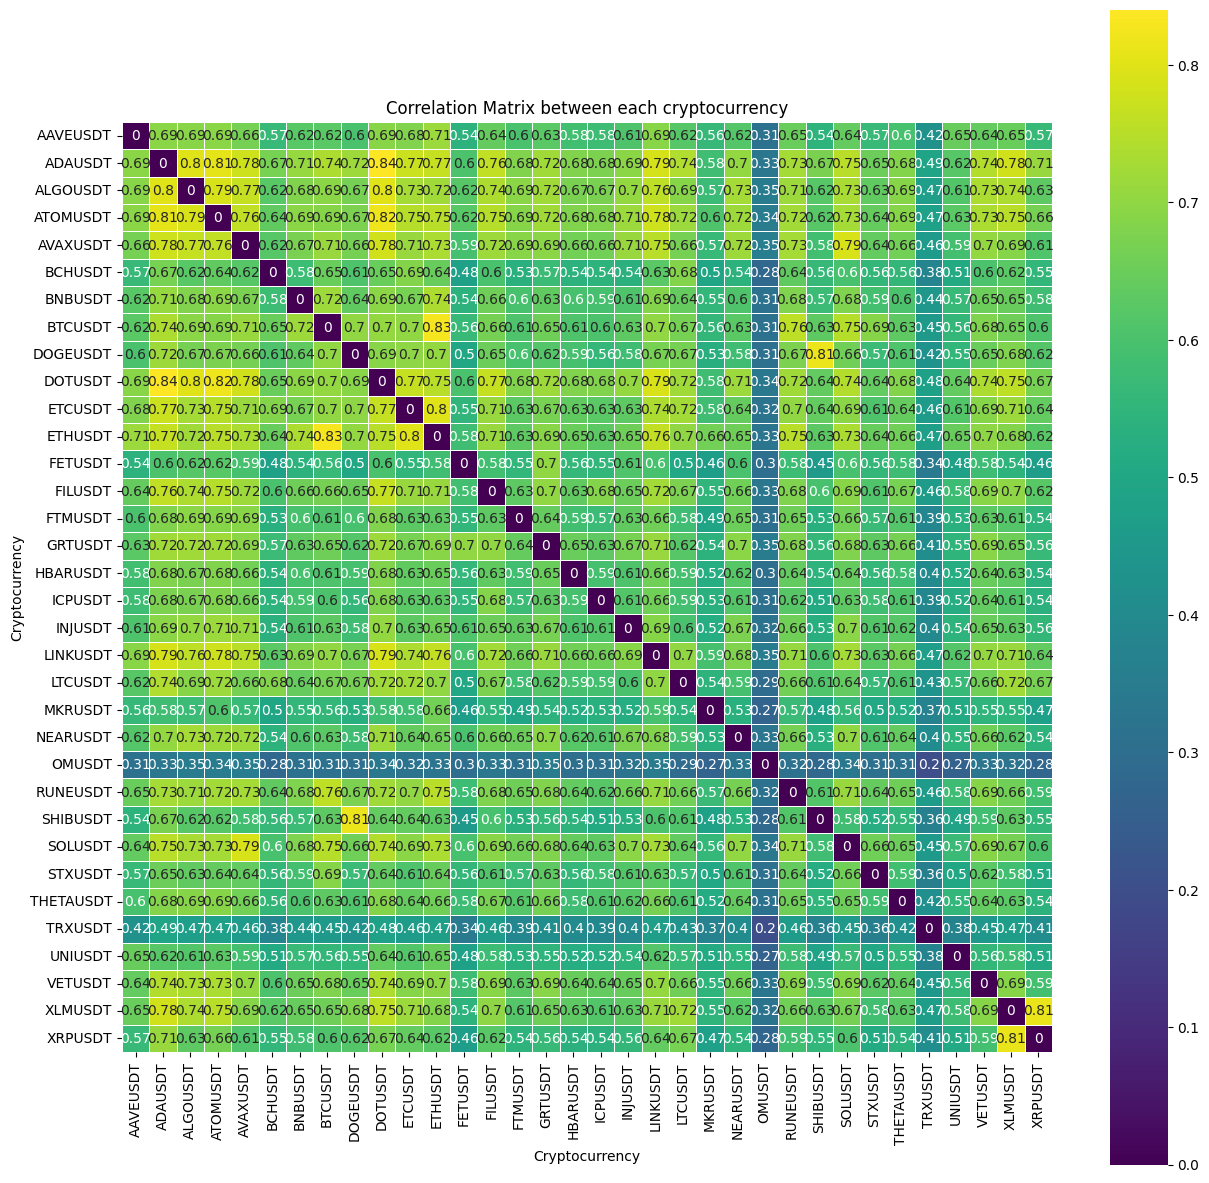

In [8]:
import seaborn as sns

correlation_matrix = df_close_filtered.diff().corr()
correlation_matrix = (correlation_matrix - (correlation_matrix == 1)) # Drop Self-Correlation

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix,
            linewidths=.5,
            annot=True,
            square=True,
            cmap="viridis")
plt.xlabel("Cryptocurrency")
plt.ylabel("Cryptocurrency")
plt.title("Correlation Matrix between each cryptocurrency")
plt.show()

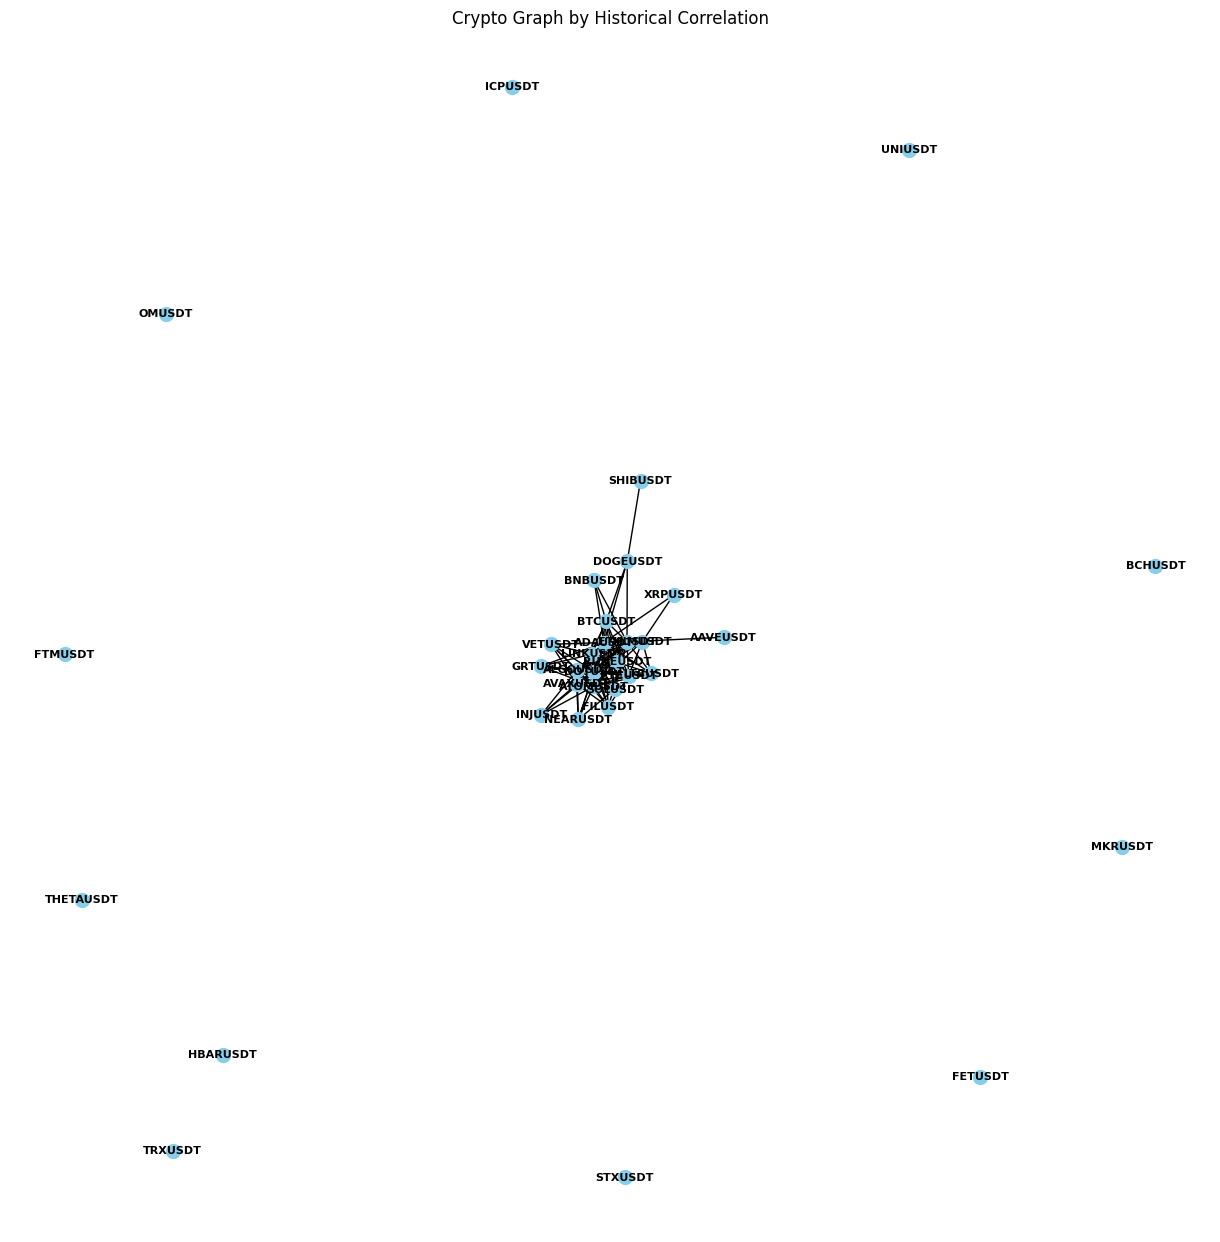

In [9]:
import networkx as nx

correlation_matrix_np = correlation_matrix.to_numpy()
adj_correlation_matrix = (correlation_matrix_np * (abs(correlation_matrix_np) > .7).astype(int)) # Threshold to form edge (0.7)

correlation_matrix_graph = nx.from_numpy_array(adj_correlation_matrix)
correlation_matrix_graph = nx.relabel_nodes(correlation_matrix_graph, dict(enumerate(correlation_matrix.index)))

plt.figure(figsize=(12, 12))
nx.draw(correlation_matrix_graph, with_labels=True, node_size=100, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(correlation_matrix_graph))
plt.title('Crypto Graph by Historical Correlation')
plt.show()

In [10]:
adj_correlation_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.7999901 , ..., 0.74281102, 0.77976407,
        0.7109679 ],
       [0.        , 0.7999901 , 0.        , ..., 0.73342326, 0.73544444,
        0.        ],
       ...,
       [0.        , 0.74281102, 0.73342326, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.77976407, 0.73544444, ..., 0.        , 0.        ,
        0.81094014],
       [0.        , 0.7109679 , 0.        , ..., 0.        , 0.81094014,
        0.        ]])

# Building PyTorch Geometric Dataset

In [10]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.7 MB/s eta 0:00:00a 0:00:01


In [11]:
import torch
from torch_geometric.data import Data

no_features = 15 # all_data.shape[1]- 4

print(all_data.shape[0])

nodes_nb = len(adj_correlation_matrix)
total_elements = all_data.shape[0] // nodes_nb
# 13780185 - 13775595 
# print(all_data.shape[0] * no_features)
# print(nodes_nb * total_elements * no_features)

Difference = all_data.shape[0] * no_features - nodes_nb * total_elements * no_features
print(Difference)
 
x = torch.tensor(
	all_data.drop(columns=["Ticker", "buy_base_vol", "buy_sell_quote_ratio", "close"]).to_numpy().reshape((nodes_nb, -1, all_data.shape[1] - 4)), dtype=torch.float32).to(device)  # shape (nodes_nb, timestamps_nb, features_nb) Note: This won't work if they are not integers
x = x.transpose(1, 2)  # shape (nodes_nb, features_nb, timestamps_nb)

close_prices = torch.tensor(
		all_data[["close"]].to_numpy().reshape((nodes_nb, -1)), dtype=torch.float32
	).to(device)

edge_nb = np.count_nonzero(adj_correlation_matrix)
edge_index, edge_weight = torch.zeros((2, edge_nb), dtype=torch.long).to(device), torch.zeros((edge_nb,), dtype=torch.float32).to(device)
count = 0
for i in range(nodes_nb):
		for j in range(nodes_nb):
			if (weight := adj_correlation_matrix[i, j]) != 0:
				edge_index[0, count], edge_index[1, count] = i, j
				edge_weight[count] = weight
				count += 1

x.shape, edge_index.shape, edge_weight.shape

918646
0


(torch.Size([34, 15, 27019]), torch.Size([2, 208]), torch.Size([208]))

In [12]:
past_window, future_window = 25, 1
timestamps = [
			Data(
				x = x[:, :, idx:idx + past_window],
				edge_index = edge_index,
				edge_weight = edge_weight,
				close_price = close_prices[:, idx:idx + past_window],
				y = x[:, 0, idx + past_window:idx + past_window + future_window],
				close_price_y=close_prices[:, idx + past_window:idx + past_window + future_window],
			).to(device) for idx in range(x.shape[2] - past_window - future_window)
		]

print(timestamps[-1])

Data(x=[34, 15, 25], edge_index=[2, 208], y=[34, 1], edge_weight=[208], close_price=[34, 25], close_price_y=[34, 1])


# Model Definition

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv

class GCN(nn.Module):
	"""
	Simple two layers GCN model.
	"""
	def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True, improved: bool = False):
		super(GCN, self).__init__()
		layer_sizes = layer_sizes or [32, 32]
		self.convs = nn.ModuleList([
		   GCNConv(in_channels, layer_sizes[0], bias=bias, improved=improved),
		] + [
		   GCNConv(layer_sizes[i], layer_sizes[i + 1], bias=bias, improved=improved) for i in
		   range(len(layer_sizes) - 1)
   		])

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
		"""
		for conv in self.convs[:-1]:
			x = F.leaky_relu(conv(x, edge_index, edge_weight))
		return self.convs[-1](x, edge_index, edge_weight)
        
class GAT(nn.Module):
	"""
	Simple two layers GCN model.
	"""
	def __init__(self, in_channels: int, layer_sizes: list[int] = None, bias: bool = True):
		super(GAT, self).__init__()
		layer_sizes = layer_sizes or [32, 32]
		self.convs = nn.ModuleList([
		   GATv2Conv(in_channels, layer_sizes[0], bias=bias, edge_dim=1),
		] + [
		   GATv2Conv(layer_sizes[i], layer_sizes[i + 1], bias=bias, edge_dim=1) for i in
		   range(len(layer_sizes) - 1)
   		])

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The hidden state of the GCN h_t (Nodes_nb, Hidden_size)
		"""
		for conv in self.convs[:-1]:
			x = F.leaky_relu(conv(x, edge_index, edge_weight))
		return self.convs[-1](x, edge_index, edge_weight)

class TGCNCell(nn.Module):
	"""
	T-GCN Cell for one timestep, from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, hidden_size: int, use_gat: bool = True):
		super(TGCNCell, self).__init__()
		if use_gat:
			self.gcn = GAT(in_channels, [hidden_size, hidden_size]).to(device)
		else:
			self.gcn = GCN(in_channels, [hidden_size, hidden_size]).to(device)
		self.lin_u = nn.Linear(2 * hidden_size + in_channels, hidden_size)
		self.lin_r = nn.Linear(2 * hidden_size + in_channels, hidden_size)
		self.lin_c = nn.Linear(2 * hidden_size + in_channels, hidden_size)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> tuple[torch.tensor, torch.tensor]:
		"""
		Performs a forward pass on a single T-GCN cell (GCN + GRU).
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
		:return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
		"""
		gcn_out = F.sigmoid(self.gcn(x, edge_index, edge_weight))  # f(A,X_t), Eq. 2
		u = F.sigmoid(self.lin_u(torch.cat([x, gcn_out, h], dim=-1)))  # u_t, Eq. 3
		r = F.sigmoid(self.lin_r(torch.cat([x, gcn_out, h], dim=-1)))  # r_t,  Eq. 4
		c = F.tanh(self.lin_c(torch.cat([x, gcn_out, r * h], dim=-1)))  # c_t, Eq. 5

		return u * h + (1 - u) * c  # h_t, Eq. 6

class TGCN(nn.Module):
	"""
	T-GCN model from https://arxiv.org/pdf/1811.05320.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(TGCN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the T-GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size).to(device) for _ in range(self.layers_nb)
		]
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
		return self.out(h_prev[-1])

class A3TGCN(nn.Module):
	"""
	A3T-GCN model from https://arxiv.org/pdf/2006.11583.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(A3TGCN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[TGCNCell(in_channels, hidden_size, use_gat=use_gat)] + [TGCNCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.attention = nn.Sequential(
			nn.Linear(hidden_size, 1),
			nn.Softmax(dim=1),
		)
		nn.init.uniform_(self.attention[0].weight)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the A3T-GCN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size).to(device) for _ in range(self.layers_nb)
		]
		h_final = torch.zeros(x.shape[0], x.shape[-1], self.hidden_size).to(device)
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
			h_final[:, t, :] = h
		return self.out(F.leaky_relu(torch.sum(F.leaky_relu(h_final) * self.attention(h_final), dim=1)))


class DCGRUCell(nn.Module):
	"""
	DCRNN Cell for one timestep, from https://arxiv.org/pdf/1707.01926.
	"""
	def __init__(self, in_channels: int, hidden_size: int, use_gat: bool = True):
		super(DCGRUCell, self).__init__()
		if use_gat:
			self.gcn_r = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_u = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_c = GAT(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
		else:
			self.gcn_r = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_u = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)
			self.gcn_c = GCN(in_channels + hidden_size, [hidden_size, hidden_size], bias=True)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor, h: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on a single DCRNN cell.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:param h: The hidden state of the GRU h_{t-1} (Nodes_nb, Hidden_size)
		:return: The hidden state of the GRU h_t (Nodes_nb, Hidden_size)
		"""
		x_h = torch.cat([x, h], dim=-1)
		r = F.sigmoid(self.gcn_r(x_h, edge_index, edge_weight))
		u = F.sigmoid(self.gcn_u(x_h, edge_index, edge_weight))
		c = F.tanh(self.gcn_c(torch.cat([x, r * h], dim=-1), edge_index, edge_weight))
		return u * h + (1 - u) * c

class DCGNN(nn.Module):
	"""
	DCGNN model from https://arxiv.org/pdf/1707.01926.
	"""
	def __init__(self, in_channels: int, out_channels: int, hidden_size: int, layers_nb: int = 2, output_activation: nn.Module = None, use_gat: bool = True):
		super(DCGNN, self).__init__()
		self.hidden_size = hidden_size
		self.layers_nb = max(1, layers_nb)
		self.cells = nn.ModuleList(
			[DCGRUCell(in_channels, hidden_size, use_gat=use_gat)] + [DCGRUCell(hidden_size, hidden_size, use_gat=use_gat) for _ in range(self.layers_nb - 1)]
		)
		self.out = nn.Sequential(
			nn.Linear(hidden_size, out_channels),
			output_activation if output_activation is not None else nn.Identity(),
		)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor) -> torch.tensor:
		"""
		Performs a forward pass on the DCRNN model.
		:param x: The feature matrix of the graph X_t (Nodes_nb, Features_nb, SeqLength)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The output of the model (Nodes_nb, OutFeatures_nb)
		"""
		h_prev = [
			torch.zeros(x.shape[0], self.hidden_size).to(device) for _ in range(self.layers_nb)
		]
		for t in range(x.shape[-1]):
			h = x[:, :, t]  # h is the output of the previous GRU layer (the input features for the first layer)
			for i, cell in enumerate(self.cells):
				h = cell(h, edge_index, edge_weight, h_prev[i])
				h_prev[i] = h
		return self.out(h_prev[-1])

print(device)

cuda


# Training and Testing

In [14]:
torch.cuda.empty_cache()

In [15]:
import torch.nn as nn
import torch.optim as optim
from torch_geometric.loader import DataLoader
torch.cuda.empty_cache()

train_part = .9
batch_size = 16

train_dataset, test_dataset = timestamps[:int(train_part * len(timestamps))], timestamps[int(train_part * len(timestamps)):]
print(f"Train dataset: {len(train_dataset)}, Test dataset: {len(test_dataset)}")
train_dataloader, test_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True), DataLoader(test_dataset, batch_size=len(test_dataset), drop_last=True)

Train dataset: 24293, Test dataset: 2700


In [16]:
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from torch_geometric.data import DataLoader
from datetime import datetime
from tqdm import trange

def measure_accuracy(model: nn.Module, data: Data) -> float:
    """
    Measure accuracy
    :param model: Model to test
    :param data: Data to test on
    :return: Accuracy
    """
    out = model(data.x, data.edge_index, data.edge_weight).to(device)
    if out.shape[1] == 1:  # Binary classification
        return (F.sigmoid(out).round() == data.y).sum().item() / len(data.y)
    else:  # Multi-class classification
        return (F.softmax(out, dim=-1).argmax(dim=-1) == data.y).sum().item() / len(data.y)
        
def test_iteration(model: nn.Module, criterion: nn.Module, test_dataloader: DataLoader, epoch: int, writer: SummaryWriter, measure_acc: bool = False) -> None:
    """
    Test iteration
    :param model: Model to test
    :param criterion: Loss function to use (MSE, CrossEntropy, ...)
    :param test_dataloader: Test data loader
    :param epoch: Current epoch
    :param writer: Tensorboard writer
    :param measure_acc: Whether to measure accuracy or not (for classification tasks)
    """
    model.eval()
    for idx, data in enumerate(test_dataloader):
        data = data.to(device) 
        out = model(data.x, data.edge_index, data.edge_weight).to(device) 
        loss = criterion(out, data.y)
        writer.add_scalar("Loss/Test Loss", loss.item(), epoch * len(test_dataloader) + idx)
        if measure_acc:
            acc = measure_accuracy(model, data)
            writer.add_scalar("Accuracy/Test Accuracy", acc, epoch * len(test_dataloader) + idx)


def train_iteration(model: nn.Module, optimizer: optim.Optimizer, pbar: trange, criterion: nn.Module, train_dataloader: DataLoader, epoch: int, writer: SummaryWriter, measure_acc: bool = False) -> None:
    """
    Train iteration
    :param model: Model to train
    :param optimizer: Optimizer to use (Adam, ...)
    :param pbar: tqdm progress bar
    :param criterion: Loss function to use (MSE, CrossEntropy, ...)
    :param train_dataloader: Train data loader
    :param epoch: Current epoch
    :param writer: Tensorboard writer
    :param measure_acc: Whether to measure accuracy or not (for classification tasks)
    """
    model.train()
    for idx, data in enumerate(train_dataloader):
        data = data.to(device) 
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({"Batch": f"{(idx + 1) / len(train_dataloader) * 100:.1f}%"})
        writer.add_scalar("Loss/Train Loss", loss.item(), epoch * len(train_dataloader) + idx)
        if measure_acc:
            acc = measure_accuracy(model, data)
            writer.add_scalar("Accuracy/Train Accuracy", acc, epoch * len(train_dataloader) + idx)

def train(model: nn.Module, optimizer: optim.Optimizer, criterion: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, num_epochs: int, task_title: str = "", measure_acc: bool = False) -> None:
    """
    Train function for a regression / classification model
    :param model: Model to train
    :param optimizer: Optimizer to use (Adam, ...)
    :param criterion: Loss function to use (MSE, CrossEntropy, ...)
    :param train_dataloader: Train data loader
    :param test_dataloader: Test data loader
    :param num_epochs: Number of epochs to train on the train dataset
    :param task_title: Title of the tensorboard run
    :param measure_acc: Whether to measure accuracy or not (for classification tasks)
    """
    writer = SummaryWriter(f'runs/{task_title}_{datetime.now().strftime("%d_%m_%Hh%M")}_{model.__class__.__name__}')
    for epoch in (pbar := trange(num_epochs, desc="Epochs")):
        train_iteration(model, optimizer, pbar, criterion, train_dataloader, epoch, writer, measure_acc)
        test_iteration(model, criterion, test_dataloader, epoch, writer, measure_acc)

# Training

In [17]:
in_channels, out_channels, hidden_size, layers_nb = timestamps[0].x.shape[-2], 1, 16, 2
tgcn_no_gat_model = TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat = False).to(device)

lr, weight_decay, num_epochs = 0.001, 1e-5, 16

criterion = nn.MSELoss()
optimizer = optim.AdamW(tgcn_no_gat_model.parameters(), lr=lr, weight_decay=weight_decay)
tgcn_no_gat_model

TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0): GCNConv(15, 16)
          (1): GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=47, out_features=16, bias=True)
      (lin_r): Linear(in_features=47, out_features=16, bias=True)
      (lin_c): Linear(in_features=47, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

In [19]:
train(tgcn_no_gat_model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "PriceForecasting_TGCN")

torch.save(tgcn_no_gat_model.state_dict(), 'tgcn_no_gat_model_epoch_16.pth')

Epochs: 100%|██████████| 16/16 [1:07:25<00:00, 252.87s/it, Batch=100.0%]


In [17]:
in_channels, out_channels, hidden_size, layers_nb = timestamps[0].x.shape[-2], 1, 16, 2
a3tgcn_no_gat_model = A3TGCN(in_channels, out_channels, hidden_size, layers_nb, use_gat = False).to(device)

lr, weight_decay, num_epochs = 0.001, 1e-5, 16

criterion = nn.MSELoss()
optimizer = optim.AdamW(a3tgcn_no_gat_model.parameters(), lr=lr, weight_decay=weight_decay)
a3tgcn_no_gat_model

A3TGCN(
  (cells): ModuleList(
    (0): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0): GCNConv(15, 16)
          (1): GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=47, out_features=16, bias=True)
      (lin_r): Linear(in_features=47, out_features=16, bias=True)
      (lin_c): Linear(in_features=47, out_features=16, bias=True)
    )
    (1): TGCNCell(
      (gcn): GCN(
        (convs): ModuleList(
          (0-1): 2 x GCNConv(16, 16)
        )
      )
      (lin_u): Linear(in_features=48, out_features=16, bias=True)
      (lin_r): Linear(in_features=48, out_features=16, bias=True)
      (lin_c): Linear(in_features=48, out_features=16, bias=True)
    )
  )
  (attention): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Softmax(dim=1)
  )
  (out): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Identity()
  )
)

In [18]:
train(a3tgcn_no_gat_model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "PriceForecasting_A3TGCN")

torch.save(a3tgcn_no_gat_model.state_dict(), 'a3tgcn_no_gat_model_epoch_16.pth')

Epochs: 100%|██████████| 16/16 [1:13:20<00:00, 275.02s/it, Batch=100.0%]


In [ ]:
in_channels, out_channels, hidden_size, layers_nb = timestamps[0].x.shape[-2], 1, 16, 2
dcgnn_no_gat_model = DCGNN(in_channels, out_channels, hidden_size, layers_nb, use_gat = False).to(device)

lr, weight_decay, num_epochs = 0.001, 1e-5, 16

criterion = nn.MSELoss()
optimizer = optim.AdamW(dcgnn_no_gat_model.parameters(), lr=lr, weight_decay=weight_decay)
dcgnn_no_gat_model

In [ ]:
train(dcgnn_no_gat_model, optimizer, criterion, train_dataloader, test_dataloader, num_epochs, "PriceForecasting_DCGNN")

torch.save(dcgnn_no_gat_model.state_dict(), 'dcgnn_no_gat_model_epoch_16.pth')

# Load Model

# Results

Printing Regression Error and plotting predictions against actual targets for comparison

In [24]:
from torch.nn import functional as F

def get_regression_error(model: nn.Module, dataloader: DataLoader) -> tuple[float, float, float, float]:
	"""
	Computes regression errors
	:param model: Model to test
	:param dataloader: Dataloader to test on
	:return: Mean squared error, rooted mean squared error, mean absolute error, mean relative error
	"""
	mse = 0
	rmse = 0
	mae = 0
	mre = 0
	for data in dataloader:
		out = model(data.x, data.edge_index, data.edge_weight)
		mse += F.mse_loss(out, data.y).item()
		rmse += F.mse_loss(out, data.y).sqrt().item()
		mae += F.l1_loss(out, data.y).item()
		mre += (F.l1_loss(out, data.y) / data.y.abs().mean()).item()
	return mse / len(dataloader), rmse / len(dataloader), mae / len(dataloader), mre / len(dataloader)

def plot_regression_all(model: nn.Module, data: Data, all_data: pd.DataFrame, title: str = None) -> None:
    """
    Plot graphs for all currencies in the regression model.
    :param model: Model to test
    :param data: Data to test on
    :param all_data: DataFrame containing all data with tickers as index level 0
    :param title: Title of the plot
    """
    model.eval()
    out = model(data.x, data.edge_index, data.edge_weight)

    preds = out.reshape(len(data.ptr) - 1, -1).cpu()
    target = data.y.reshape(len(data.ptr) - 1, -1).cpu()

    # Extract tickers from the DataFrame
    tickers = all_data.index.levels[0].tolist()
    
    num_currencies = len(tickers)
    num_cols = 4  # Number of plots per row
    num_rows = (num_currencies + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    fig.suptitle(title)

    # Flatten the axes array for easy indexing
    axs = axs.flatten()

    for idx in range(num_currencies):
        ax = axs[idx]
        ax.plot(target[:, idx].detach().numpy(), label="Real")
        ax.plot(preds[:, idx].detach().numpy(), label="Predicted")
        ax.set_title(f"Currency: {tickers[idx]}")
        ax.legend()

    # Hide any unused subplots
    for j in range(num_currencies, num_rows * num_cols):
        axs[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include title
    plt.show()

In [21]:
# A3TCGN Model Results (No Attention Mechanism)
mse, rmse, mae, mre = get_regression_error(a3tgcn_no_gat_model, train_dataloader)
print(f"Train MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Train MSE: 28910126569362563268608.0000, RMSE: 119146269273.3219, MAE: 10815507001.8065, MRE: 1.0000


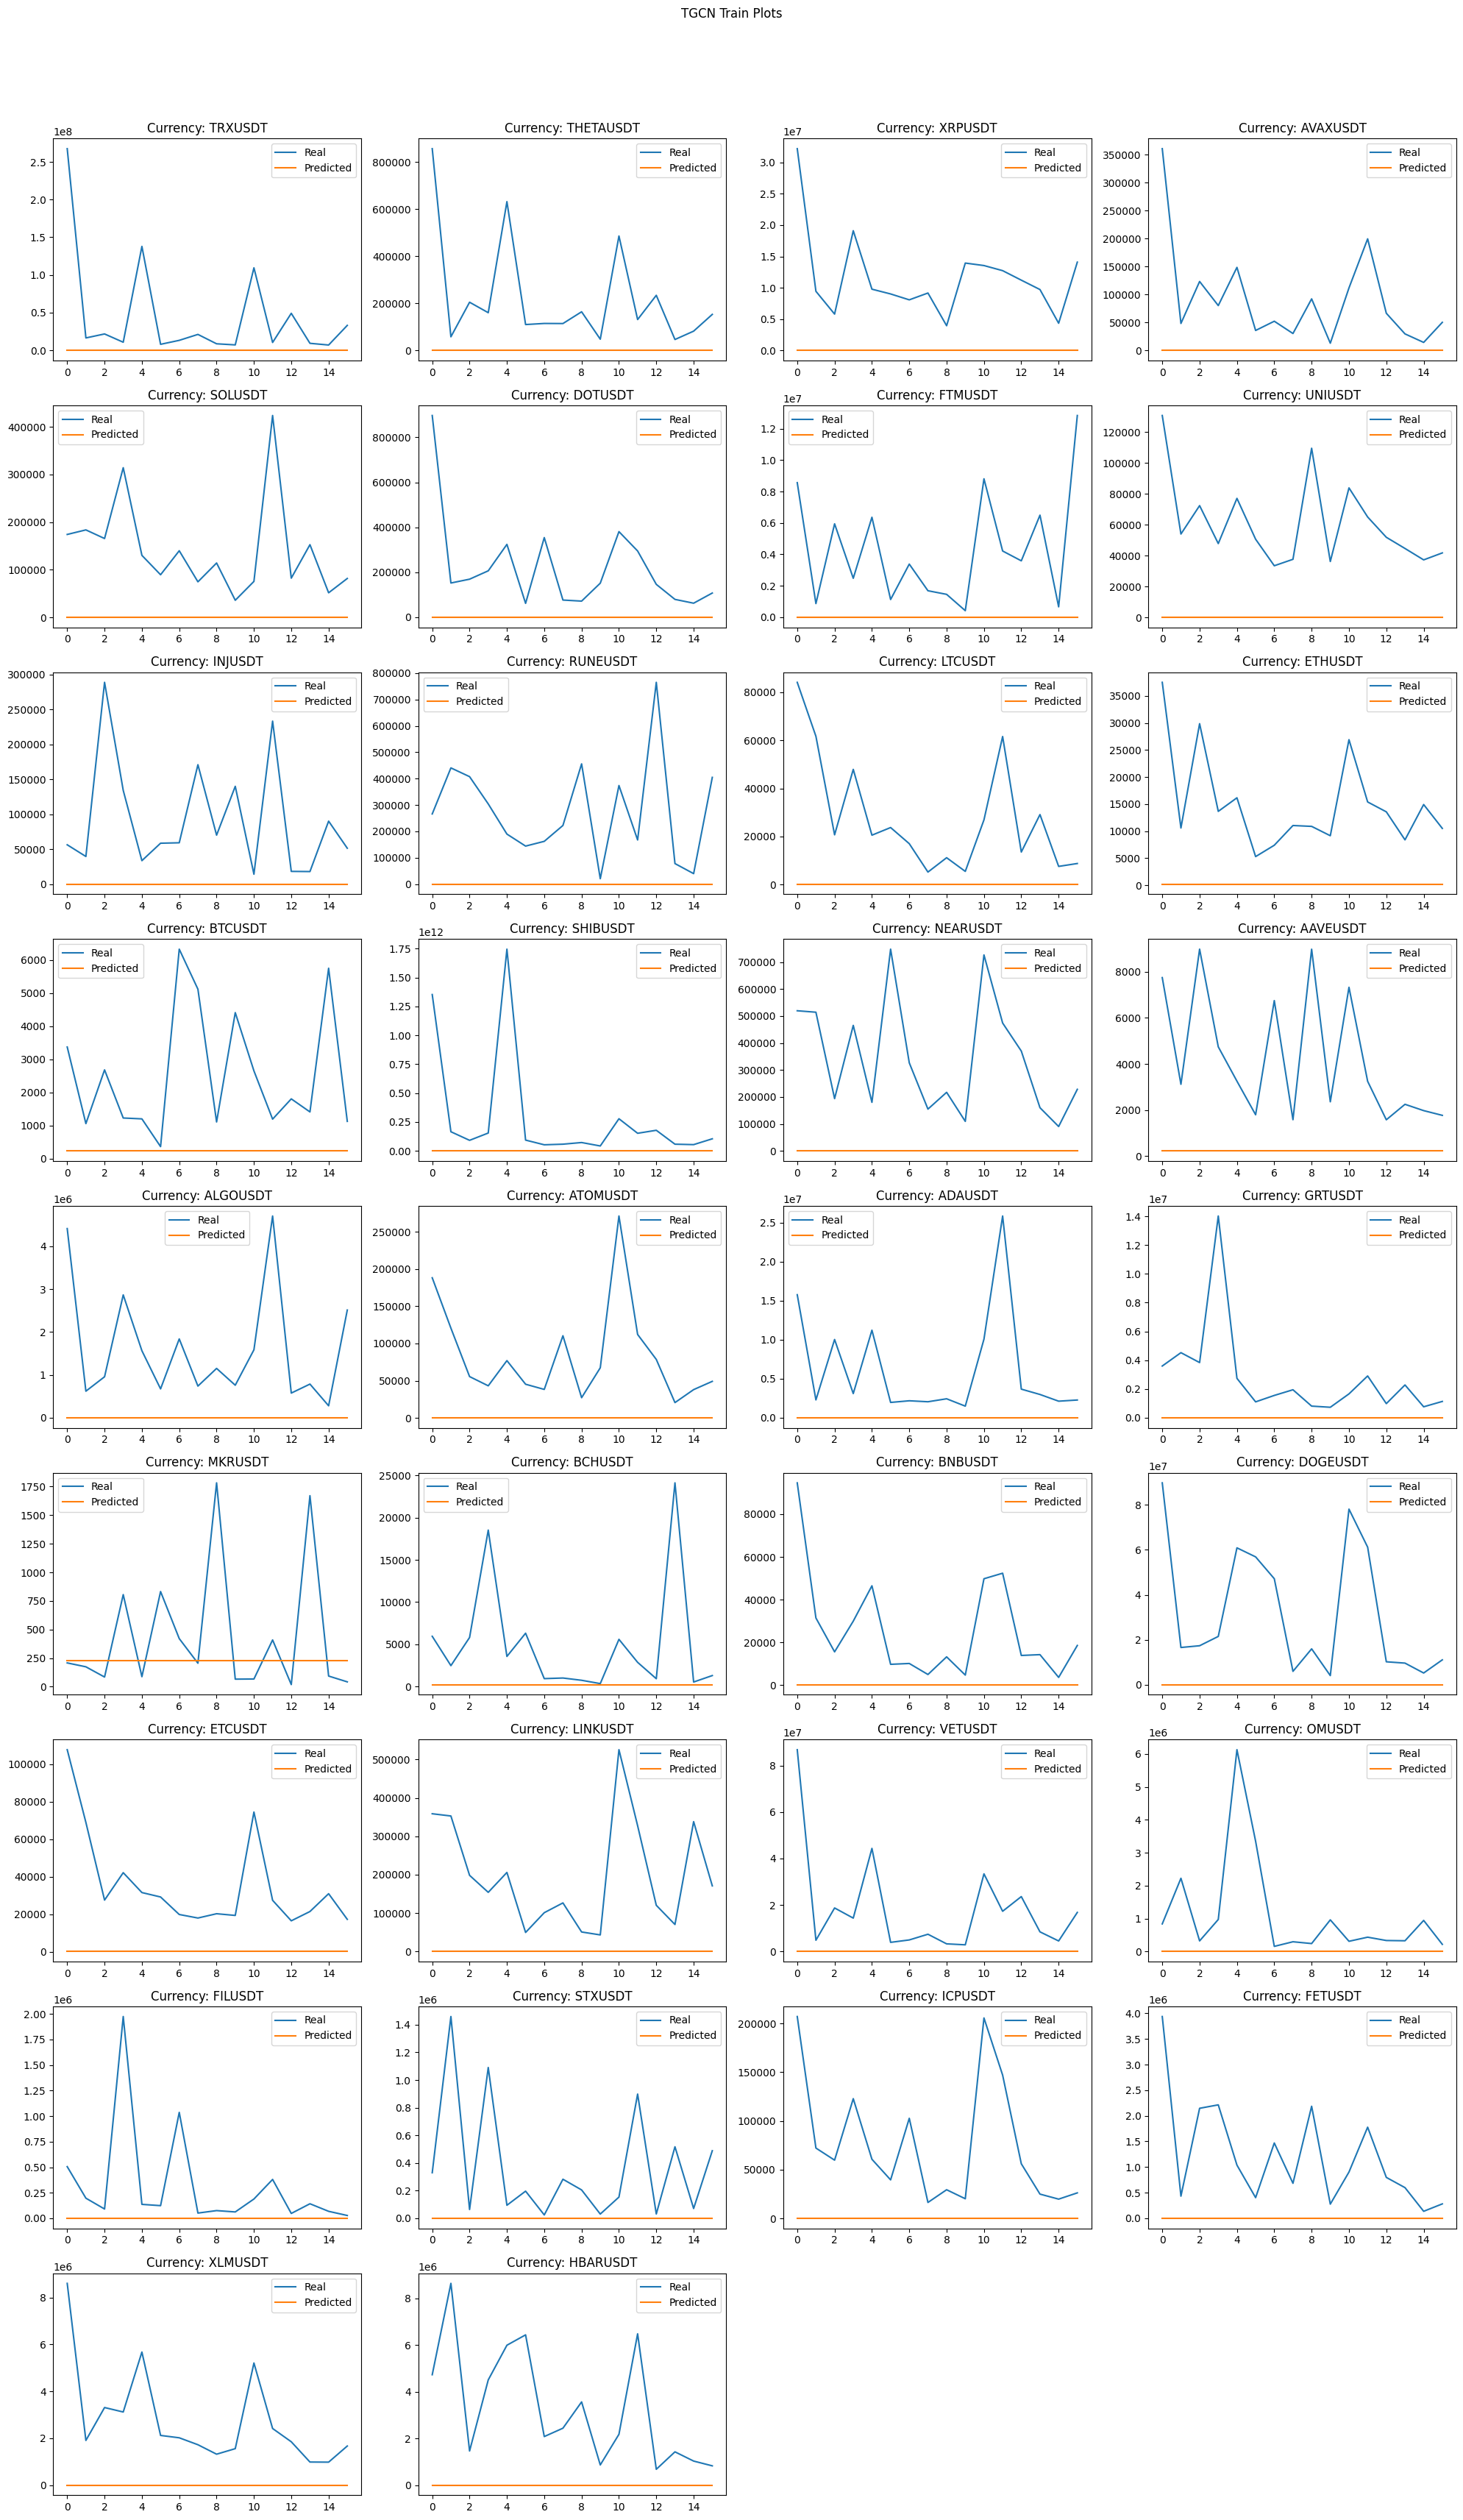

In [25]:
plot_regression_all(a3tgcn_no_gat_model, next(iter(train_dataloader)), all_data, "TGCN Train Plots")

In [26]:
# A3TGCN Test Results
mse, rmse, mae, mre = get_regression_error(a3tgcn_no_gat_model, test_dataloader)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, MRE: {mre:.4f}")

Test MSE: 1781822452446349230080.0000, RMSE: 42211639296.0000, MAE: 4122274560.0000, MRE: 1.0000


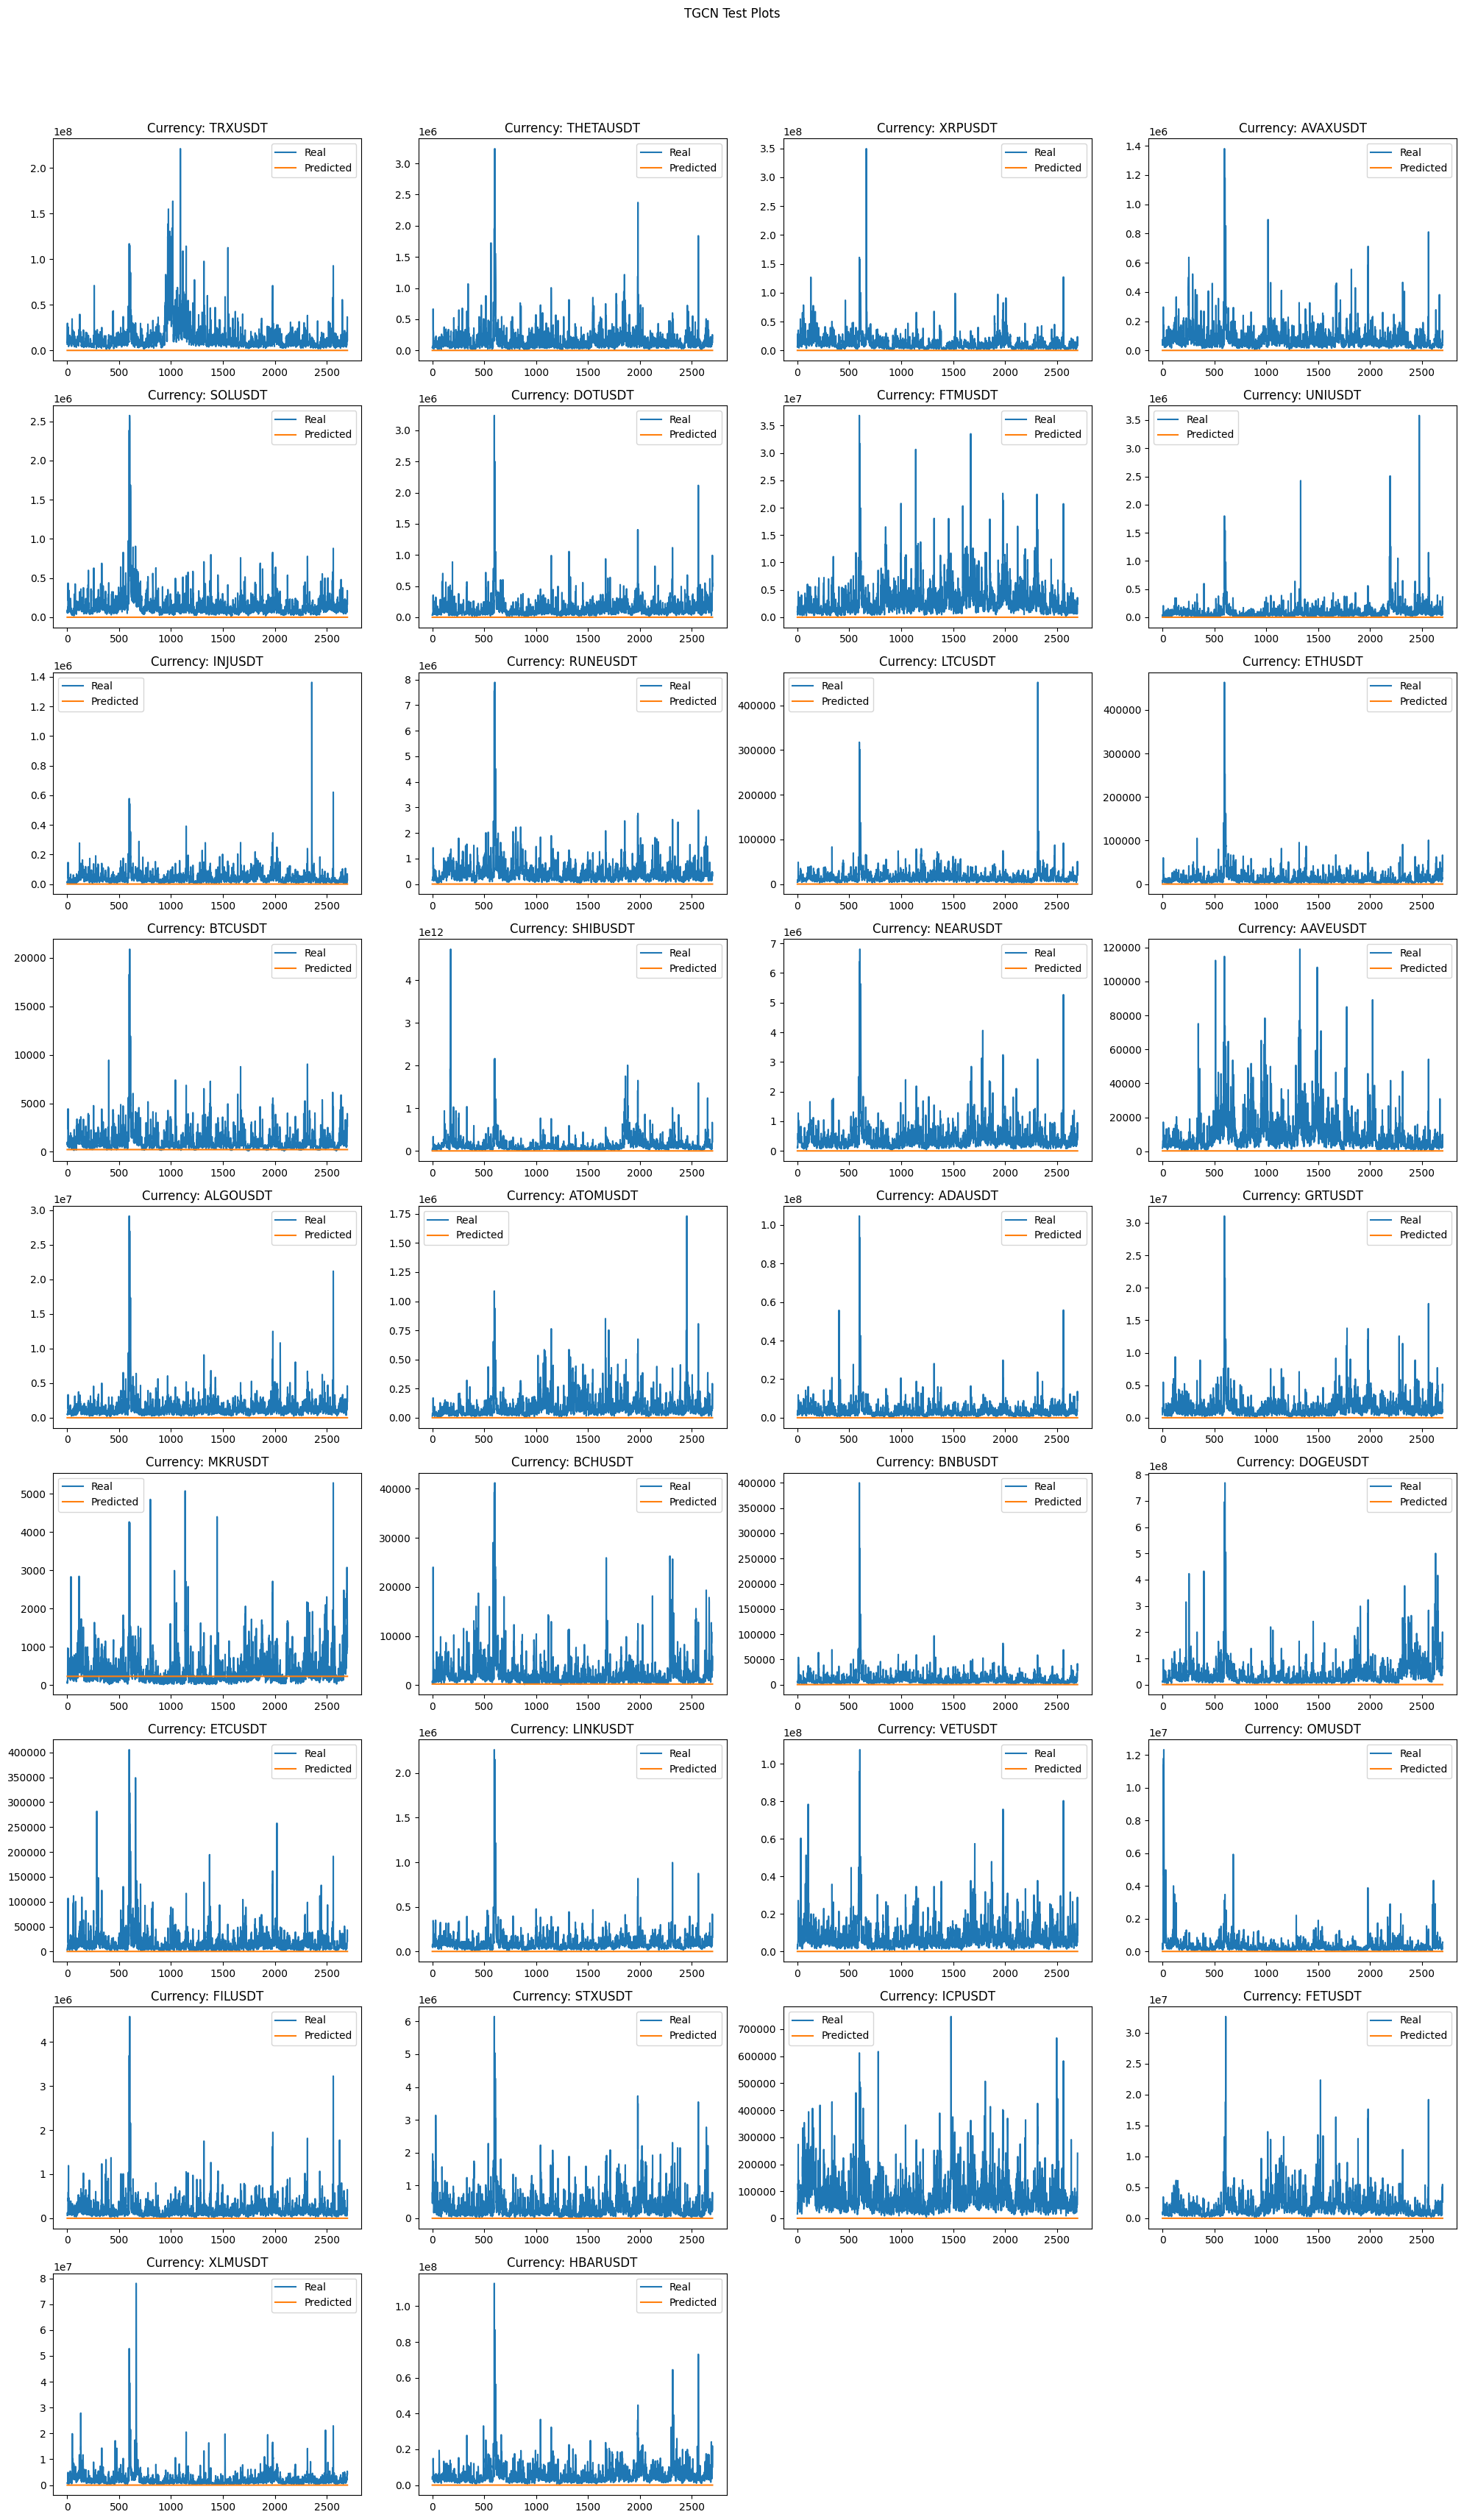

In [28]:
plot_regression_all(a3tgcn_no_gat_model, next(iter(test_dataloader)), all_data, "TGCN Test Plots")